# Часть 1
## Разложение временных рядов с помощью метода SSA

В этом учебном пособии будет представлена техника **анализа сингулярного спектра (SSA)**, метода декомпозиции временных рядов. SSA разлагает временной ряд на набор суммируемых компонентов, которые группируются вместе и интерпретируются как *тренд*, *периодичность* и *шум*. SSA отчетливо показывает **разделимость** базовых компонент и может легко выделять цикличность, возникающую в разных временных масштабах, даже в очень зашумленных данных временных рядов. Исходный временной ряд восстанавливается путем суммирования всех его компонент.

Таким образом, SSA можно использовать для анализа и реконструкции временных рядов с различными компонентами или без них по желанию. Примеры использования SSA:
* Сглаженная версия временного ряда, с использованием небольшого подмножества его компонентов;
* Поиск периодических компоненты временного ряда, чтобы понять основные процессы, которые породили временной ряд;
* Реконструировать исходный временной ряд без его периодических составляющих;
* Удаление всех трендовых и периодических компонент из ряда, оставив только "шум", который может иметь значение.



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler
from ssa_module import plot_2d, X_to_TS, Hankelise, components_auto_group, SSA_simple_plt, SSA_plt_groups, SSA

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# 1. Загрузка данных <a name="Section1"></a>

In [10]:
data = pd.read_csv("data/data_gulf_of_finland.csv")
# изначально у нас 2651 записей с  2012 по 2020 год, обрезаем "лишние" (2 дня за 2020 и сентябрь-декабрь 2021)
data = data.loc[data["NAME"] == "BELOGORKA, RS"][122:-2] # берем ежедневные данные о температуре, собранные с 1 станции в ЛО
data = data.set_index("DATE") # установим дату в качестве индекса
data.TEMP = (data.TEMP - 32) * 5/9 # преобразуем из градусов по Фаренгейту в градусы по Цельсию
data["TEMP"]

DATE
2013-01-01    1.388889
2013-01-02    0.833333
2013-01-03    0.277778
2013-01-04   -1.166667
2013-01-05   -3.166667
                ...   
2019-12-27   -0.611111
2019-12-28   -2.777778
2019-12-29   -5.388889
2019-12-30    1.833333
2019-12-31    1.833333
Name: TEMP, Length: 2527, dtype: float64

Text(0, 0.5, 'temp')

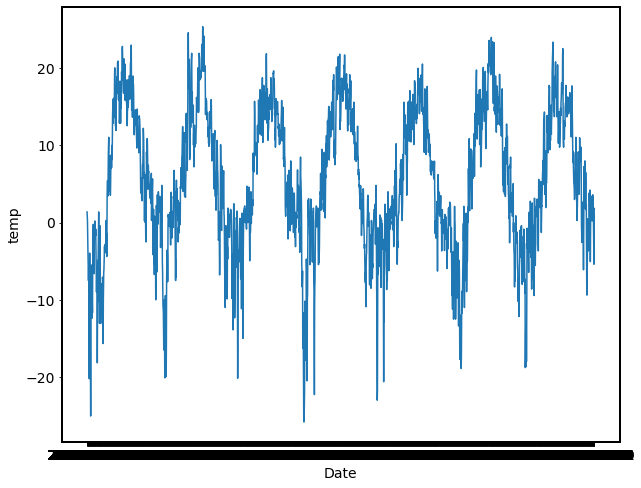

In [11]:
plt.plot(data.TEMP)
plt.xlabel("Date")
plt.ylabel("temp")

# 2. Введение в метод SSA<a name="Section2"></a>
## 2.1 Переход к таректорной матрице<a name="Section2.1"></a> 
Первым шагом SSA является сопоставление временного ряда $F$ с последовательностью многомерных векторов задержек. Пусть целое число $L$ будет длиной **окна**, $2 \le L \le N/2$. Таким образом формируется окно из подпоследовательностей $\{f_i, \ f_{i+1}, \ldots , \ f_{i+L-1}\}$, для  $i=0,\ldots,N-L$.

\begin{align*}
X_0 & = (f_0, \ f_1, \ f_2,  \ldots, \ f_{L-1} )^{\text{T}} \\
X_1 & = (f_1, \ f_2, \ f_3,  \ldots, \ f_L )^{\text{T}} \\
X_2 & = (f_2, \ f_3, \ f_4,  \ldots, \ f_{L+1} )^{\text{T}} \\
X_3 & = (f_3, \ f_4, \ f_5,  \ldots, \ f_{L+2} )^{\text{T}} \\
& \quad \quad \quad  \vdots \\
X_{N-L} & = (f_{N-L}, \ f_{N-L+1}, \ f_{N-L+2}, \ \ldots, \ f_{N-1} )^{\text{T}}.
\end{align*}

Эти вектора образуют $L$-*траекторной матрицы*, $\mathbf{X}$, временного ряда:

$$\mathbf{X} = \begin{bmatrix}
f_0 & f_1 & f_2 & f_3 &\ldots & f_{N-L} \\ 
f_1 & f_2 & f_3 & f_4 &\ldots & f_{N-L+1} \\
f_2 & f_3 & f_4 & f_5 &\ldots & f_{N-L+2} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_{L-1} & f_{L} & f_{L+1} & f_{L+2} & \ldots & f_{N-1} \\ 
\end{bmatrix}$$

Из приведенной выше матрицы видно, что элементы *антидиагоналей* (то есть диагоналей, идущих снизу слева направо) равны. Этот тип матрицы известен как ***Ганкелева*** матрица.

$K = N - L + 1$ представляют количество столбцов в матрице траекторий. **Мы будем называть столбцы $\mathbf{X}$ векторами задержек $L$, а строки-векторами задержек $K$.**

In [12]:
F = data.TEMP.values
N = len(F)
L = round(N * 0.3) # Длина окна - 30% от длины ряда
print(N, L)
K = N - L + 1 # Число колонок в траекторной матрице
# Создаем траекторную матрицу, вытянув соответствующие подпоследовательности из F и сложив их в виде столбцов.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Примечание: i+L выше дает нам до i+L-1, так как верхние границы массива numpy не включаются.

2527 758


Text(0.5, 1.05, 'Траекторная матрица')

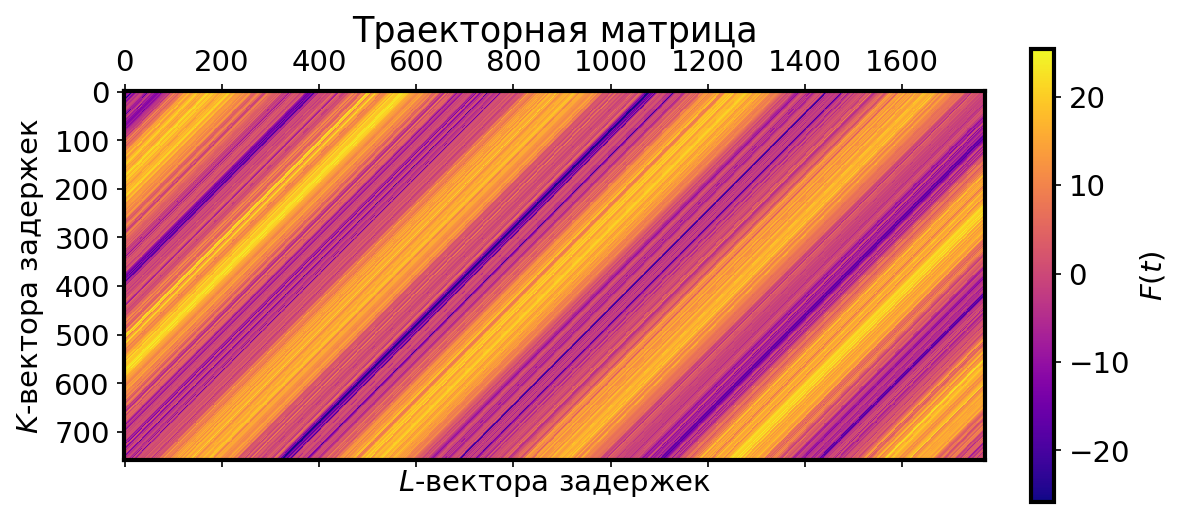

In [13]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax = ax.matshow(X)
plt.xlabel("$L$-вектора задержек")
plt.ylabel("$K$-вектора задержек")
fig.colorbar(ax, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("Траекторная матрица", pad=15)

Визуализация траекторной матрицы:
1. Элементы на антидиагоналях равны
2. Значения чередуются с определенным шагом

## 2.2 Разложение траекторной матрицы<a name="Section2.2"></a>
Разложим нашу траекторную матрицу с помощью SVD [singular-value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition),

$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$ 
где:
* $\mathbf{U}$ размера $L \times L$ ортонормированная матрица ***левых сингулярных векторов*** of $\mathbf{X}$;
* $\mathbf{\Sigma}$ размера $L \times K$ прямоугольная диагональная матрица $L$ ***сингулярных значений*** of $\mathbf{X}$, упорядоченных от большего к меньшему;
* $\mathbf{V}$ размера $K \times K$ ортонормированная матрица ***правых сингулярных векторов*** of $\mathbf{X}$.

мы перевели временной ряд $F = \{f_0, \ldots, f_{N-1}\}$ в набор векторов-столбцов, $X_i = (f_i, f_{i+1}, \ldots, f_{i+L-1})^{\text{T}}, i = 0, \ldots, N-L$, которые образуют траекторную матрицу $\mathbf{X}$. Потом разложили через SVD; нашли два ортонормированных базиса, $\mathcal{U}$ and $\mathcal{V}$, которые образуют пространство строк и колонок траекторной матрицы.
\begin{align*}
    \mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
               & \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
$i$-ое сингулярное значение $\sigma_i$, определяет относительный вклад $\mathbf{X}_i$ в $\mathbf{X}$. Число $d \le L$ может быть выбрано для получение аппроксимации пониженной размерности $\mathbf{X}$ сумммируя только первые $r < d$ элементарных матриц.

 Сфокусируемся на восстановлении компонентов временного ряда по его элементарным матрицам.

In [14]:
d = np.linalg.matrix_rank(X) 

U, Sigma, V = np.linalg.svd(X)
V = V.T 

# Вычислите элементарные матрицы X, сохранив их в многомерном массиве NumPy. Для этого требуется вычислить sigma_i * U_i * (V_i)^T для каждого i 
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Быстрая проверка: сумма всех элементарных матриц в X_elm должна быть равна X, с точностью до определенного порога:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

Рассмотрим первые 12 элементарных матриц

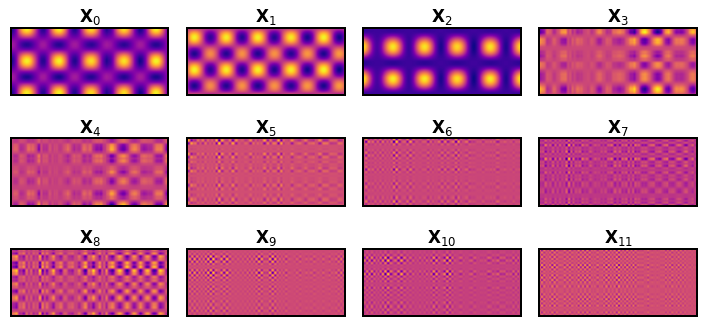

In [15]:
n = min(12, d)
for i in range(n):
    plt.subplot(5,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

здесь мы видим тренд на х0 матрице, и, скорее всего, х1 тоже принадлежит тренду, т.к. имеет схожие паттерны
начиная от х5 идут шумы, х3 и х4 - периодические компоненты, а х2 визуально кажется более близкой к тренду,
 так или иначе, ожидается, что х1, х0 и х3, х4 будут объединены (автогруппировкой)

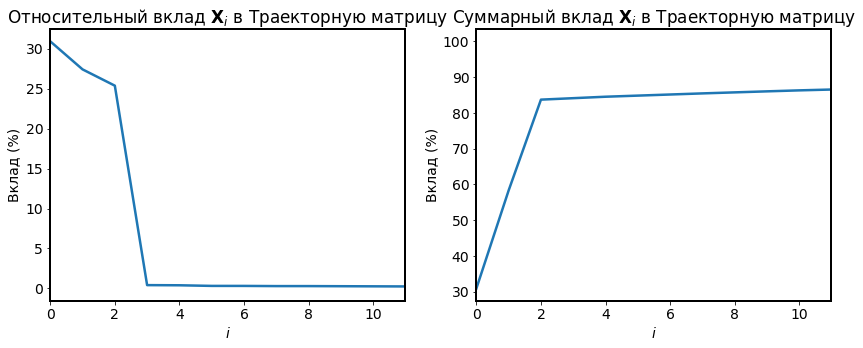

In [16]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Относительный вклад $\mathbf{X}_i$ в Траекторную матрицу")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Вклад (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Суммарный вклад $\mathbf{X}_i$ в Траекторную матрицу")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Вклад (%)");

 х0 и х1 суммарно вносят около 60% в траекторную матрицу, х2 вносит ~ 25%.
 В совокупности первые три элементарных матриц составляют ~85%.
Визуально видно, что первые две матрицы вносят примерно равный вклад и их можно обьединить.
Начиная с x3 вклад становится менее 5% и мы не видим существенных изменений,
 следовательно, оставшиеся компоненты можно убрать из ряда.

## 2.Восстановление исходного ряда<a name="Section2.3"></a>
До сих пор мы сопоставляли временной ряд $F$ с рядом векторов с запаздыванием $L$, формируя матрицу траекторий$ F$. Затем мы разложили эту матрицу с помощью сингулярного разложения и построили набор *элементарных матриц*, которые составляют матрицу траекторий. Затем мы дали небольшое объяснение, размахивая руками, чтобы классифицировать эти элементарные матрицы как *тренд*, *периодичность* и *шум*.

В идеальном мире все компоненты временного ряда $F = \sum_j F^{(j)}$ были бы разделимыми, и мы бы сгруппировали полученные элементарные матрицы $\mathbf{X}_i$ соответствующим образом, так что
\begin{align*} 
\mathbf{X} & = \sum_{k \in \mathcal{S}}\mathbf{X}_k + \sum_{l \in \mathcal{T}}\mathbf{X}_l + \ldots \\
& = \sum_j \mathbf{X}^{(j)}
\end{align*} 
где $\mathcal{S}$ и $\mathcal{T}$-непересекающиеся наборы индексов, а $\mathbf{X}^{(j)}$ - траекторная матрица компонента временного ряда $F^{(j)}$. В этом случае каждый $\mathbf{X}^{(j)}$ будет иметь Ганкелеву структуру и построение каждого $F^{(j)}$ будет простым. Однако в этом несовершенном реальном мире ни одна траекторная матрица компонентов не будет иметь равных значений на своих антидиагоналях. Поэтому мы ищем процесс преобразования элементарной матрицы в матрицу Ханкеля, а затем во временной ряд.

Чтобы извлечь временной ряд из элементарных матриц, мы будем использовать ***диагональное усреднение***, которое определяет значения восстановленного временного ряда $\tilde{F}^{(j)}$ как средние значения соответствующих антидиагоналей матриц $\mathbf{X}^{(j)}$. Формально это выполняется с помощью оператора Ганкеля. $\hat{\mathcal{H}}$, который действует на матрицу $L \times K$  $\mathbf{X}^{(j)}$ и переводит ее в Ганкелеву матрицу $\mathbf{\tilde{X}}^{(j)}$; такую что, 
$$\mathbf{\tilde{X}}^{(j)} = \hat{\mathcal{H}}\mathbf{X}^{(j)}$$ 
Элемент $\tilde{x}_{m,n}$ in $\mathbf{\tilde{X}}^{(j)}$, для $s = m+n$
$$
\tilde{x}_{m,n} = \left\{
  \begin{array}{lr}
    \frac{1}{s+1}\sum_{l=0}^{s} x_{l, s-l} & \ 0 \le s \le L-1 \\
    \frac{1}{L-1}\sum_{l=0}^{L-1} x_{l, s-l} & \ L \le s \le K-1 \\
    \frac{1}{K+L-s-1}\sum_{l=s-K+1}^{L} x_{l, s-l} & \ K \le s \le K+L-2 \\
  \end{array}
\right.
$$

На первый взгляд, все вышесказанное выглядит как ад-адок-адище. Однако все, что он делает, - это вычисляет заданную $\tilde{x}_{m,n}$ путем усреднения остальных элементов антидиагонали,к которой принадлежит $\tilde{x}_{m, n}$. Количество антидиагональных элементов для суммирования зависит от расположения $m$ и $n$ в матрице. **На практике нам не нужна полная матрица Ханкеля $\mathbf{\tilde{X}}^{(j)}$, и мы можем сразу перейти к построению временного ряда $\tilde{F}^{(j)}$. Тем не менее, я включил определение $\hat{\mathcal{H}}\mathbf{X}^{(j)}$ выше, чтобы завершить математическое изложение SSA.**

Важно отметить, что $\hat{\mathcal{H}}$ является линейным оператором, т. е. $\hat{\mathcal{H}}(\mathbf{A} + \mathbf{B}) = \hat{\mathcal{H}}\mathbf{A} + \hat{\mathcal{H}}\mathbf{B}$. Затем для матрицы траекторий $\mathbf{X}$,
\begin{align*} 
\hat{\mathcal{H}}\mathbf{X} & = \hat{\mathcal{H}} \left( \sum {i=0}^{d-1} \mathbf{X}_i \right) \\
& = \sum_{i=0}^{d-1} \hat{\mathcal{H}} \mathbf{X}_i \\
& \equiv \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}
\end{align*} 
Поскольку $\mathbf{X}$ уже является матрицей Ханкеля, то по определению $\hat{\mathcal{H}}\mathbf{X} = \mathbf{X}$. Следовательно, матрица траекторий может быть выражена в терминах ее элементарных матриц Ханкеля:
$$\mathbf{X} = \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}$$
Поскольку временной ряд однозначно определяется из матрицы Ханкеля, приведенное выше выражение также определяет временной ряд $F$ как сумму его компонентов $\tilde{F}_i$. Мы должны сгруппировать эти компоненты вместе и классифицировать их.

KeyboardInterrupt: 

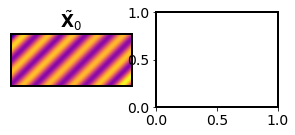

In [17]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

здесь мы также видим, что начиная с х5 идут шумы, х0-х4 визуально больше напоминают периодические компоненты

In [ ]:
n = min(12,d) 
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(F_i, lw=2)

fig.axes.plot(F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("Первые 12 компонент исходного ряда")
fig.legend(legend, loc=(1.05,0.1));

на рисунке видно, что х0 и х1 практически повторяют друг друга, х2 близко к х1 х0,
х3 и х4 почти не заметны на фоне шумов

# 3. Разделение и группировка компонентов временных рядов 

До сих пор мы группировали собственные элементы/компоненты временного ряда вместе путем визуального осмотра; то есть мы решили, какие компоненты принадлежат друг другу по их внешнему виду. Это хорошо для коротких и простых временных рядов, однако для более длинных и сложных временных рядов мы ищем метод, который количественно определяет, можно ли считать реконструированный компонент $\tilde{F}_i$ отдельным от другого компонента $\tilde{F}_j$, поэтому нам не нужно принимать решения о группировке, визуально проверяя каждую $\tilde{F}_i$.

Для двух реконструированных временных рядов, $\tilde{F}_i$ и $\tilde{F}_j$, длиной $N$ и длиной окна $L$, мы определяем *взвешенное скалярное произведение*, $(\tilde{F}_i, \tilde{F}_j)_w$ как:
$$(\tilde{F}_i, \tilde{F}_j)_w = \sum {k=0}^{N-1} w_k \tilde{f}_{i,k} \tilde{f}_{j,k}$$
где $\tilde{f}_{i,k}$ и $\tilde{f}_{j,k}$ находятся в $k$ - ых значениях $\tilde{F}_i$ и $\tilde{F}_j$, соответственно, и $w_k$ дается
$$
w_{k} = \left\{
  \begin{array}{lr}
    k+1 & \ 0 \le k \le L-1 \\
    L & \ L \le k \le K-1 \\
    N - k & \ K \le k \le N-1 \\
  \end{array}
\right.
$$
помня, что $K = N - L + 1$. Вес $w_k$ просто отражает количество раз, когда $\tilde{f}_{i,k}$ и $\tilde{f}_{j,k}$ появляются в матрицах Ганкеля $\mathbf{\tilde{X}}_i$ и $\mathbf{\tilde{X}}_j$, из которых были получены временные ряды $\tilde{F}_i$ и $\tilde{F}_j$.

Проще говоря, если $(\tilde{F}_i, \tilde{F}_j)_w = 0$, $\tilde{F}_i$ и $\tilde{F}_j$ являются *w-ортогональными* и компоненты временных рядов разделимы. Конечно, полная w-ортогональность не встречается в реальной жизни, поэтому вместо этого мы определяем матрицу $d \times d$ ***взвешенной корреляции***, $\mathbf{W}_{\text{corr}}$, которая измеряет отклонение компонентов $\tilde{F}_i$ и $\tilde{F}_j$ от w-ортогональности. Элементы $\mathbf{i}_{\text{Corr}}$ дает
$$W_{i,j} = \frac{(\tilde{F}_i, \tilde{F}_j)_w}{\lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w}$$
where $\lVert \tilde{F}_k \rVert_w = \sqrt{(\tilde{F}_k, \tilde{F}_k)_w}$ for $k = i,j$. The interpretation of $W_{i,j}$ is straightforward: if $\tilde{F}_i$ and $\tilde{F}_j$ are arbitrarily close together (but not identical), then $(\tilde{F}_i, \tilde{F}_j)_w \rightarrow \lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w$ and therefore $W_{i,j} \rightarrow 1$. Если $\tilde{F}_i$ и $\tilde{F}_j$ ортогональны, тогда $W_{i,j} = 0$. Значения $W_{i,j}$ находятся в пределах от 0 до 1 и указывают $W_{i,j} \ge 0.3$ какие компоненты надо сгруппировать.

In [ ]:
# Сначала получите веса w, так как они будут часто использоваться повторно.
# Примечание: список(np.arange(L)+1) возвращает последовательность от 1 до L (первая строка в определении w),
# [L]*(K-L-1) повторяет L K-L-1 раз (вторая строка в определении w)
# список(np.arange(L)+1)[::-1] отменяет первый список (эквивалентно третьей строке)
# Сложите все списки вместе, и у нас будет наш массив весов.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Получите все компоненты серии игрушек, сохраните их в виде столбцов в массиве F_elem.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Вычислите индивидуальные взвешенные нормы, ||F_i||_w, сначала, затем возьмите обратный квадратный корень, чтобы нам не пришлось делать это позже.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Вычислите матрицу w-corr. Диагональные элементы равны 1, поэтому мы можем начать с матрицы идентичности
# и повторите все пары i и j (i != j), отметив, что Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

In [ ]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("Матрица W-корреляций временного ряда");

In [ ]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"Матрица корелляций для компонентов с индексом 0–6");


In [ ]:
# Группируем элементы между собой, основываясь на значениях корреляции
result_groups = components_auto_group(Wcorr)
F_trend = X_to_TS(X_elem[result_groups[0]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[result_groups[1]].sum(axis=0))
# получили следующие значения - [[0, 1, 2], [3, 4], [5, 6]]
plt.plot(data.TEMP, lw=1)
plt.plot(F_trend)
plt.plot(F_periodic1)

if len(result_groups) > 3:
    F_periodic2 = X_to_TS(X_elem[result_groups[2]].sum(axis=0))
    F_noise = X_to_TS(X_elem[result_groups[3][0]:].sum(axis=0))
    groups = ["тренд", "циклика 1", "циклика 2", "шум"]
    plt.plot(F_periodic2)
else:
    F_noise = X_to_TS(X_elem[result_groups[2][0]:].sum(axis=0))
    groups = ["тренд", "циклика 1", "шум"]

plt.plot(F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$" % group for group in groups]
plt.legend(legend)
plt.title("Сгрупированные компоненты")

 мы достаточно хорошо отделили тренд от шума, однако остаются вопросы к х3 и х4

# 5. Длина окна<a name="Section5"></a>

### 5.1 $L = 2$ <a name="Section5.1"></a>
Теперь рассмотрим различные длины окна
На окнах длиной 2-5 сложно хорошо отделить даже шумовую составляющую для нашего ряда

In [ ]:
SSA_simple_plt(data.TEMP, window_size=2)

In [ ]:
SSA_simple_plt(data.TEMP, window_size=5)

теперь посмотрим на больших длинах окна, начиная от месяца и заканчивая 2 годами

In [ ]:
SSA_plt_groups(data.TEMP, window_size=30)

здесь уже шум хорошо отделяется

In [ ]:
SSA_plt_groups(data.TEMP, window_size=60)

In [ ]:
SSA_plt_groups(data.TEMP, window_size=90)

In [ ]:
SSA_plt_groups(data.TEMP, window_size=180)

дойдя до 180 мы четко видим х0 и х1 - трендовые компоненты, однако после х2 мы все еще видим только шум
при L 180 х2 начинает объединяться с трендом в группировке

In [ ]:
SSA_plt_groups(data.TEMP, window_size=365)

здесь мы уже хорошо видим х2, который имеет высокую корреляцию с х0 и х1

In [ ]:
SSA_plt_groups(data.TEMP, window_size=550)

начинает выделяться циклическая составляющая,
по результатам автоматической группировки выделяются х0-х2 как тренд и х3, х4 как циклика

In [ ]:
SSA_plt_groups(data.TEMP, window_size=730)

возьмем "ровные" два года - здесь х2 уже имеет меньшую корреляцию с х0-х2
и, скорее, напоминает какую-то периодическую составляющую, при этом не связанную с х3-х4

In [ ]:
SSA_plt_groups(data.TEMP, window_size=1095)

2,5 года - теперь наши х3 х4 явно выделяются на фоне шума
тем не менее, х0, х1 и другие компоненты все равно все равно выглядят скорее как периодичность, чем тренд,
вероятно имеет смысл взять ряд большей длины, например, на 20-30 лет

попробуем окно на 365, сгруппировав самостоятельно

In [ ]:
F_ssa_L365 = SSA(data.TEMP, 365)
plt.plot(data.TEMP, lw=1)
F_ssa_L365.reconstruct([0, 1]).plot()
F_ssa_L365.reconstruct([2]).plot()
F_ssa_L365.reconstruct([3, 4]).plot()
F_ssa_L365.reconstruct(slice(5, 365)).plot(alpha=0.7)
plt.title("Сгруппированные (вручную) компоненты, $L=365")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
groups = ["тренд", "циклика 1", "циклика 2", "шум"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$" % group for group in groups]
plt.legend(legend)
plt.show()

в данном случае x3 и x4 еще достаточно сильно зашумлены, но мы уже видим некую периодичность